In [ ]:
# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import tree
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score

# Importing and Creating Training & Testing Sets


In [3]:
original_train = pd.read_csv('../train.csv',header = 0)
original_train['dataset'] = 'train'
print original_train.shape

(10886, 13)


In [4]:
original_test = pd.read_csv('../test.csv',header = 0)
original_test['dataset'] = 'test'
print original_test.shape

(6493, 10)


In [5]:
df_complete =  original_train.copy().append(original_test.copy())
#df_complete = df_complete.drop(['casual','registered'], axis = 1)
df_complete = df_complete.drop(['count'], axis = 1)

In [6]:
#add the natural dissater feature
df_complete['nat_dis'] = 0


In [7]:
# Make the datetime the index
df_complete['datetime'] = pd.to_datetime(df_complete['datetime'])

df_complete.index = df_complete['datetime']
del df_complete['datetime']


In [8]:
# Make sure we have all the complete values of the series
idx = pd.date_range('2011-01-01 00:00:00', '2012-12-31 23:00:00', freq='H')
df_complete = df_complete.reindex(idx)

In [9]:
# Missing entries? let's try to interpolate to get that info
missing = df_complete[pd.isnull(df_complete['atemp'])]
missing.shape

(165, 12)

In [10]:
df_complete["weather"] = df_complete["weather"].interpolate(method='time').apply(np.round)
df_complete["temp"] = df_complete["temp"].interpolate(method='time')
df_complete["atemp"] = df_complete["atemp"].interpolate(method='time')
df_complete["humidity"] = df_complete["humidity"].interpolate(method='time').apply(np.round)
df_complete["windspeed"] = df_complete["windspeed"].interpolate(method='time')
df_complete["season"] = df_complete["season"].interpolate(method='time').apply(np.round)
df_complete["workingday"] = df_complete["workingday"].interpolate(method='time').apply(np.round)
df_complete["holiday"] = df_complete["holiday"].interpolate(method='time').apply(np.round)
#df_complete["nat_dis"] = df_complete["season"].interpolate(method='time').apply(np.round)
#df_complete["count"] = df_complete["count"].interpolate(method='time').apply(np.round)

#df_complete.loc[missing.index, "dataset"] = 'train'
#df_complete.loc[df_complete['dataset']=='test', 'count'] = float('NaN')

In [11]:
missing2 = df_complete[pd.isnull(df_complete['atemp'])]
missing2.shape

(0, 12)

In [12]:
df_complete.loc[missing.index].head()

,atemp,casual,dataset,holiday,humidity,registered,season,temp,weather,windspeed,workingday,nat_dis
2011-01-02 05:00:00,21.9675,NaN,NaN,0.0,86.0,NaN,1.0,18.040000,2.0,16.498750,0.0,NaN
2011-01-03 02:00:00,7.8300,NaN,NaN,0.0,45.0,NaN,1.0,7.653333,1.0,27.333767,1.0,NaN
2011-01-03 03:00:00,7.3250,NaN,NaN,0.0,46.0,NaN,1.0,7.106667,1.0,26.668233,1.0,NaN
2011-01-04 03:00:00,8.3325,NaN,NaN,0.0,63.0,NaN,1.0,5.740000,1.0,7.500650,1.0,NaN
2011-01-05 03:00:00,10.6075,NaN,NaN,0.0,61.0,NaN,1.0,8.200000,1.0,10.502250,1.0,NaN


In [13]:
df_complete['month'] = df_complete.index.month
#df_complete['dayOfMonth'] = df_complete.index.day
df_complete['day'] = df_complete.index.dayofweek
df_complete['week'] = df_complete.index.week
df_complete['hour'] = df_complete.index.hour
df_complete['year'] = df_complete.index.year


In [14]:
df_complete['weekend'] = ((df_complete.index.dayofweek == 5) | (df_complete.index.dayofweek == 6)).astype(int)


# Initial Data View

In [ ]:
df_complete[df_complete['dataset']=='test'].head(2)

In [ ]:
df_complete.describe()

In [ ]:
df_complete.dtypes

In [ ]:
df_complete.shape

# Utils

In [15]:
# Function that prints the prediction according the submission format
def printPrediction(pred, fileName='pred.csv'):
    str_prediction = "datetime,count\n"
    for i in range(0, len(pred)):
        datetime = original_test['datetime'][i]
        currentPred = int(round(pred[i]))
        str_prediction += "{},{}\n".format(datetime, currentPred)

    #print str_prediction
    f = open(fileName,'w')
    f.write(str_prediction)
    f.close()

In [16]:
# Function that gets the range of an specific day
def get_day_range(day):
    day_end = day + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day, day_end, freq="H")

In [17]:
def predictWithModel(model, train_x, train_y_c, train_y_r, test_x):
    pred_c = []
    pred_r = []

    years = [2011, 2012]
    for y in years:
        print 'Predicting: {}'.format(y)
        train_mask = (train_x['year'] == y)
        train_mask = train_mask.values

        test_mask = (test_x['year'] == y)
        test_mask = test_mask.values


        model.fit(train_x[train_mask][features_casual], train_y_c[train_mask])
        pred_c_current = np.array(model.predict(test_x[test_mask][features_casual]))
        pred_c = np.concatenate((pred_c, pred_c_current), axis = 0)

        model.fit(train_x[train_mask][features_registered], train_y_r[train_mask])
        pred_r_current = np.array(model.predict(test_x[test_mask][features_registered]))
        pred_r = np.concatenate((pred_r, pred_r_current), axis = 0)


    return pred_c + pred_r
    

# Adding new Features

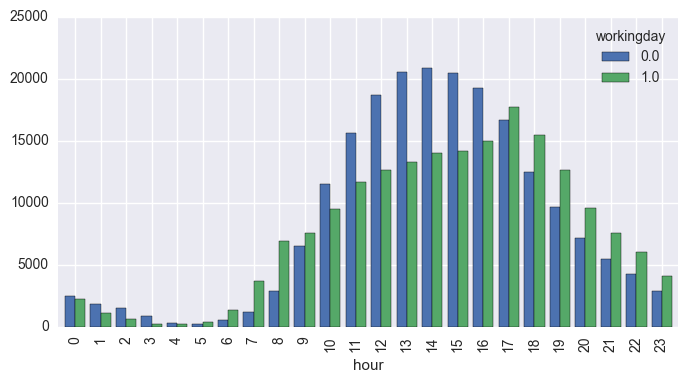

In [41]:
# rentals by hour, split by working day (or not)
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['hour', 'workingday'])['casual'].agg('sum').unstack()

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);

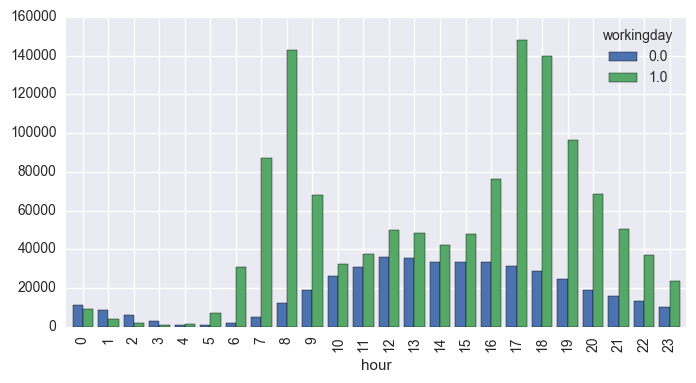

In [42]:
# rentals by hour, split by working day (or not)
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['hour', 'workingday'])['registered'].agg('sum').unstack()

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);

In [75]:
## Add Rush Hours according to histograms
df_complete['casual_rush'] = df_complete[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  7 <= x['hour'] <= 23)
        or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)

df_complete['registered_rush'] = df_complete[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  (6 <= x['hour'] <= 9 or 16 <= x['hour'] <= 23))
        or (x['workingday'] == 0 and  8 <= x['hour'] <= 23)], axis = 1)

In [19]:
## Add feature that indicates if it's raining or not
df_complete['rain'] = ((df_complete['weather'] == 3) | (df_complete['weather'] == 4)).astype(int)
#del df_complete['weather']

In [20]:
## add quarters by year
df_complete['year_quarter'] = 1

df_complete.loc[(df_complete.index.year == 2011)
                & (1 <= df_complete.index.month)
                & (df_complete.index.month <= 3),
                'year_quarter'] = 1
df_complete.loc[(df_complete.index.year == 2011) 
                & (4 <= df_complete.index.month) 
                & (df_complete.index.month <= 6)
                , 'year_quarter'] = 2
df_complete.loc[(df_complete.index.year == 2011)
                & (7 <= df_complete.index.month) 
                & (df_complete.index.month <= 9)
                , 'year_quarter'] = 3
df_complete.loc[(df_complete.index.year == 2011)
                & (10 <= df_complete.index.month) 
                & (df_complete.index.month <= 12)
                , 'year_quarter'] = 4
df_complete.loc[(df_complete.index.year == 2012)
                & (1 <= df_complete.index.month) 
                & (df_complete.index.month <= 3)
                , 'year_quarter'] = 5
df_complete.loc[(df_complete.index.year == 2012)
                & (4 <= df_complete.index.month) 
                & (df_complete.index.month <= 6)
                , 'year_quarter'] = 6
df_complete.loc[(df_complete.index.year == 2012)
                & (7 <= df_complete.index.month) 
                & (df_complete.index.month <= 9)
                , 'year_quarter'] = 7
df_complete.loc[(df_complete.index.year == 2012)
                & (10 <= df_complete.index.month) 
                & (df_complete.index.month <= 12)
                , 'year_quarter'] = 8


##Make bins for the continous variables
df_complete['b_temp'] = pd.cut(df_complete['temp'], 5, labels=False)
df_complete['b_atemp'] = pd.cut(df_complete['atemp'], 5, labels=False)
df_complete['b_humidity'] = pd.cut(df_complete['humidity'], 5, labels=False)
df_complete['b_windspeed'] = pd.cut(df_complete['windspeed'], 5, labels=False)

In [ ]:
df_complete.head(n=2)

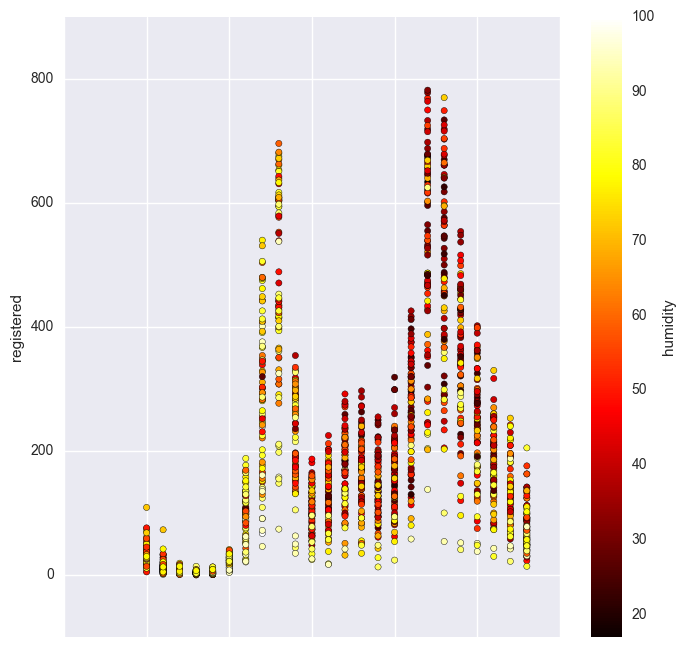

In [21]:

# rentals by hour, split by working day (or not)
by_hour = df_complete[(df_complete['dataset'] == 'train')
                      &(df_complete['workingday'] == 1)
                      & (df_complete['season'] == 2)].copy()#.groupby(['hour', 'workingday'])['registered'].agg('sum').unstack()
by_hour = by_hour[['hour', 'registered', 'humidity']]
#by_hour.columns = ['hour', 'no', 'yes']
by_hour.head(n=200)
by_hour.plot(kind='scatter', x='hour', y='registered', c='humidity', cmap='hot', figsize=(8,8));


In [ ]:
#df_complete['ideal'] = df_complete[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
#df_complete['sticky'] = df_complete[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)

In [22]:
## Adding some missed "holydays"

# tax day
df_complete.loc[get_day_range(pd.datetime(2011, 4, 15)), "workingday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 4, 16)), "workingday"] = 1

# thanksgiving friday
df_complete.loc[get_day_range(pd.datetime(2011, 11, 25)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 11, 23)), "workingday"] = 0

# tax day
df_complete.loc[get_day_range(pd.datetime(2011, 4, 15)), "holiday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 4, 16)), "holiday"] = 0

# thanksgiving friday
df_complete.loc[get_day_range(pd.datetime(2011, 11, 25)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 11, 23)), "holiday"] = 1

#pre christmas / new year
df_complete.loc[get_day_range(pd.datetime(2011, 12, 24)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 12, 24)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 12, 24)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 12, 24)), "workingday"] = 0

df_complete.loc[get_day_range(pd.datetime(2011, 12, 31)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 12, 31)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 12, 31)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 12, 31)), "workingday"] = 0




#storms
df_complete.loc[get_day_range(pd.datetime(2012, 5, 21)), "nat_dis"] = 1
#tornado
df_complete.loc[get_day_range(pd.datetime(2012, 6, 1)), "nat_dis"] = 1

#January 8–13, 2011 North American blizzard
df_complete.loc[get_day_range(pd.datetime(2011, 1, 9)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 1, 10)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 1, 11)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 1, 12)), "nat_dis"] = 1

#Earthquake Aug. 23, 2011
df_complete.loc[get_day_range(pd.datetime(2011, 8, 23)), "nat_dis"] = 1

#Hurricane Irene 21 - 30  Aug-11
df_complete.loc[get_day_range(pd.datetime(2011, 8, 22)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 8, 23)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 8, 24)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 8, 25)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 8, 26)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 8, 27)), "nat_dis"] = 1


In [ ]:

# Compute the correlation matrix
corr = df_complete[df_complete['dataset'] == 'train'].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(256, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

## Contruct Training and Testing Sets

In [76]:
df_train = df_complete[df_complete['dataset'] == 'train']
del df_train['dataset']


df_train_y_c = df_train['casual'].values
df_train_y_r = df_train['registered'].values
df_train_y = df_train_y_c + df_train_y_r

df_train_x = df_train.drop(['casual', 'registered'],axis = 1)#.values

In [77]:
df_test = df_complete[df_complete['dataset'] == 'test']
del df_test['dataset']
#del df_test['count']
del df_test['casual']
del df_test['registered']

# Models

In [93]:
# Cross Validation Generator
cv = cross_validation.ShuffleSplit(len(df_train_x), n_iter=3, test_size=0.2,
    random_state=0)

# features to use
# month reduces the accuracy considerable
# year_quarter also reduces accuracy
# week also reduces the accuracy
features_common = ['humidity', 'atemp', 'temp', 'windspeed', 'weather', 'rain', 'season', 'holiday',   
        'workingday', 'weekend', 'day', 'hour']

features_casual = features_common + ['casual_rush']
features_registered = features_common + ['registered_rush']

 ## Time Series

In [ ]:
type(df_train)

In [ ]:
dates = pd.date_range('2011-01-01 00:00:00', '2012-12-19 23:00:00', freq='H')
#original_train.sort_values('datetime', ascending = True).head()
dates

In [ ]:
AO = pd.Series(df_train['count'], index=dates)
AO

In [ ]:
#df_train[['datetime', 'temp']]

## Decision Tree

In [ ]:
#Finding best parameters
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    df_train_x, df_train_y, test_size=0.3, random_state=0)

tuned_parameters = [
    {'max_depth':[9,10,11,20,25,50]},
    {'min_samples_leaf':[1,2,5,10,50,100]},
    {'min_samples_split':[1,2,5,10,50,100]},
    {'presort':[True, False]},
    {'min_weight_fraction_leaf':[0.0, 0.1, 0.3, 0.4, 0.5]}]   
    
scores = ['r2']

for score in scores:
    
    print score
    
    clf = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    
    #best_estimator_ returns the best estimator chosen by the search
    print(clf.best_estimator_)
    print ""
    print("Grid scores on development set:")
    print ""
    #grid_scores_ returns:
    #    * a dict of parameter settings
    #    * the mean score over the cross-validation folds 
    #    * the list of scores for each fold
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print ""

In [ ]:
# Cross Validation
dtr = tree.DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
for train, test in cv:
    clf = dtr.fit(df_train_x[train], df_train_y[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        clf.score(df_train_x[train], df_train_y[train]), clf.score(df_train_x[test], df_train_y[test])))

In [ ]:
# Best Model
dtr = tree.DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [53]:
# Predicting & Exporting File
dtr_pred = predictWithModel(dtr, df_train_x, df_train_y_c, df_train_y_r, df_test)
printPrediction(dtr_pred)

NameError: name 'dtr' is not defined

## Random Forest

In [ ]:
#Finding best parameters
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    df_train_x, df_train_y, test_size=0.3, random_state=0)

tuned_parameters = [
    {'max_depth':[50,100, 500, 1000]}, #Best: 1000
    #{'n_estimators':[1000, 10000]}, #We assume is 1000
    {'min_samples_leaf':[1,2,5,10,50,100]}, #2
    {'min_samples_split':[1,2,5,10,50,100]}, #10
    {'min_weight_fraction_leaf':[0.0, 0.1, 0.3, 0.4, 0.5]}] #0.0    
    
scores = ['r2']

for score in scores:
    
    print score
    
    clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    
    #best_estimator_ returns the best estimator chosen by the search
    print(clf.best_estimator_)
    print ""
    print("Grid scores on development set:")
    print ""
    #grid_scores_ returns:
    #    * a dict of parameter settings
    #    * the mean score over the cross-validation folds 
    #    * the list of scores for each fold
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print ""


In [ ]:
# Cross Validation
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=2,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
#rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
#           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
#           min_samples_split=1, min_weight_fraction_leaf=0.0,
#           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
#           verbose=0, warm_start=False)

    
for train, test in cv:
    clf = rfr.fit(df_train_x[train], df_train_y[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        clf.score(df_train_x[train], df_train_y[train]), clf.score(df_train_x[test], df_train_y[test])))

In [46]:
#Optimized model
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=2,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)



In [94]:
# Predicting Year by Year
rfr_pred = predictWithModel(rfr, df_train_x, df_train_y_c, df_train_y_r, df_test)
printPrediction(rfr_pred)

Predicting: 2011
Predicting: 2012


## XBoost Regressor

In [29]:
#xgb_model = xgb.XGBRegressor()
#clf = GridSearchCV(xgb_model,
#                   {'max_depth': [2,4,6],
#'n_estimators': [50,100,200]}, verbose=1)


#Finding best parameters
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    df_train_x, df_train_y, test_size=0.3, random_state=0)

tuned_parameters = [
    {'max_depth': [2,5,10,100,1000]},
    {'n_estimators': [50,100,500,1000]}]  
    
scores = ['r2']

for score in scores:
    
    print score
    
    xgbr = GridSearchCV(xgb.XGBRegressor(), tuned_parameters, cv=5, scoring=score)
    xgbr.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    
    #best_estimator_ returns the best estimator chosen by the search
    print(xgbr.best_estimator_)
    print ""
    print("Grid scores on development set:")
    print ""
    #grid_scores_ returns:
    #    * a dict of parameter settings
    #    * the mean score over the cross-validation folds 
    #    * the list of scores for each fold
    for params, mean_score, scores in xgbr.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print ""


r2
Best parameters set found on development set:
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Grid scores on development set:

0.837 (+/-0.003) for {'max_depth': 2}
0.946 (+/-0.002) for {'max_depth': 5}
0.951 (+/-0.003) for {'max_depth': 10}
0.946 (+/-0.004) for {'max_depth': 100}
0.946 (+/-0.004) for {'max_depth': 1000}
0.864 (+/-0.003) for {'n_estimators': 50}
0.899 (+/-0.002) for {'n_estimators': 100}
0.938 (+/-0.002) for {'n_estimators': 500}
0.945 (+/-0.003) for {'n_estimators': 1000}



In [30]:
#Optimized model
xgbr = XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1000,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [95]:
# Predicting Year by Year
xgbr_pred = predictWithModel(xgbr, df_train_x, df_train_y_c, df_train_y_r, df_test)
printPrediction(xgbr_pred)

Predicting: 2011
Predicting: 2012


## Merging models

In [ ]:
rfr_dtr_merged_pred = 0.9 * rfr_pred + 0.1 * xgbr_pred
printPrediction(rfr_dtr_merged_pred)

In [96]:
rfr_xgbr_merged_pred = 0.3 * rfr_pred + 0.7 * xgbr_pred
printPrediction(rfr_xgbr_merged_pred)